Task: Regular Classification

Select high-quality venues, use venues as class labels, and construct classification models to classify papers and authors into different venues using their TF-IDF features. Compare different classifiers' performance using different evaluation metrics (e.g., accuracy, macro-F1, micro-F1). 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
# Load Data
df_class = pd.read_parquet("data/classification_df.parquet")

K = 10 
top_venues = df_class["venue"].value_counts().head(K).index
df_class = df_class[df_class["venue"].isin(top_venues)].copy()

print("Number of venues after filtering:", df_class["venue"].nunique())
print(df_class["venue"].value_counts())

df_class.head()


Number of venues after filtering: 10
venue
                                                                        506699
Lecture Notes in Computer Science                                        32137
international conference on acoustics, speech, and signal processing     26621
international conference on robotics and automation                      19943
international conference on image processing                             18336
international conference on communications                               17679
international symposium on circuits and systems                          16945
global communications conference                                         15850
international geoscience and remote sensing symposium                    15390
intelligent robots and systems                                           14698
Name: count, dtype: int64


,abstract,authors,n_citation,references,title,venue,year,id,Abstract,author_count,text
3,None,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec,,5,Development of Remote Monitoring and Control D...
4,None,"[Giovanna Guerrini, Isabella Merlo]",2,None,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266,,2,Reasonig about Set-Oriented Methods in Object ...
6,None,"[Jovan Dj. Golic, Guglielmo Morgari]",2,None,Vectorial fast correlation attacks.,,2004,00638a94-23bf-4fa6-b5ce-40d799c65da7,,2,Vectorial fast correlation attacks.
10,Recent achievements in Natural Language Proces...,"[Ankita Brahmachari, Priya Singh, Avdhesh Garg...",0,"[84d47128-58d0-4187-aa44-389fde7d5c83, e0dce69...",Identifying Psychological Theme Words from Emo...,,2013,00a119c4-d367-4607-b3c8-b237f2971bff,Recent achievements in Natural Language Proces...,4,Identifying Psychological Theme Words from Emo...
11,None,"[David Al-Dabass, Christopher Goodwin, K. Siva...",0,None,Simulation of a vision steering system for roa...,,1995,00ba1eb4-d1aa-4587-892b-d9dcc38c1a78,,3,Simulation of a vision steering system for roa...


In [8]:
N = 2000

df_class = (
    df_class.groupby("venue", group_keys=False)
            .apply(lambda g: g.sample(min(len(g), N), random_state=42))
            .reset_index(drop=True)
)

print("Rows after downsampling:", len(df_class))
print(df_class["venue"].value_counts())


Rows after downsampling: 20000
venue
                                                                        2000
Lecture Notes in Computer Science                                       2000
global communications conference                                        2000
intelligent robots and systems                                          2000
international conference on acoustics, speech, and signal processing    2000
international conference on communications                              2000
international conference on image processing                            2000
international conference on robotics and automation                     2000
international geoscience and remote sensing symposium                   2000
international symposium on circuits and systems                         2000
Name: count, dtype: int64


C:\Users\14693\AppData\Local\Temp\ipykernel_22432\1812080925.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), N), random_state=42))


In [9]:
#TF-IDF Vectorization

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=3000,   
    min_df=5,            
    max_df=0.6           
)
X = tfidf.fit_transform(df_class["text"])
y = df_class["venue"]

X.shape


(20000, 3000)

In [10]:
#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape)
print("Test:", X_test.shape)



Train: (16000, 3000)
Test: (4000, 3000)


In [11]:
#SGD Classifier

sgd = SGDClassifier(
    loss="log_loss",
    max_iter=10,
    tol=1e-3,
    n_jobs=-1,
    random_state=42
)
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)


c:\Users\14693\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [12]:

print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Macro F1:", f1_score(y_test, y_pred_sgd, average="macro"))
print("Micro F1:", f1_score(y_test, y_pred_sgd, average="micro"))


Accuracy: 0.579
Macro F1: 0.5757721152471544
Micro F1: 0.579


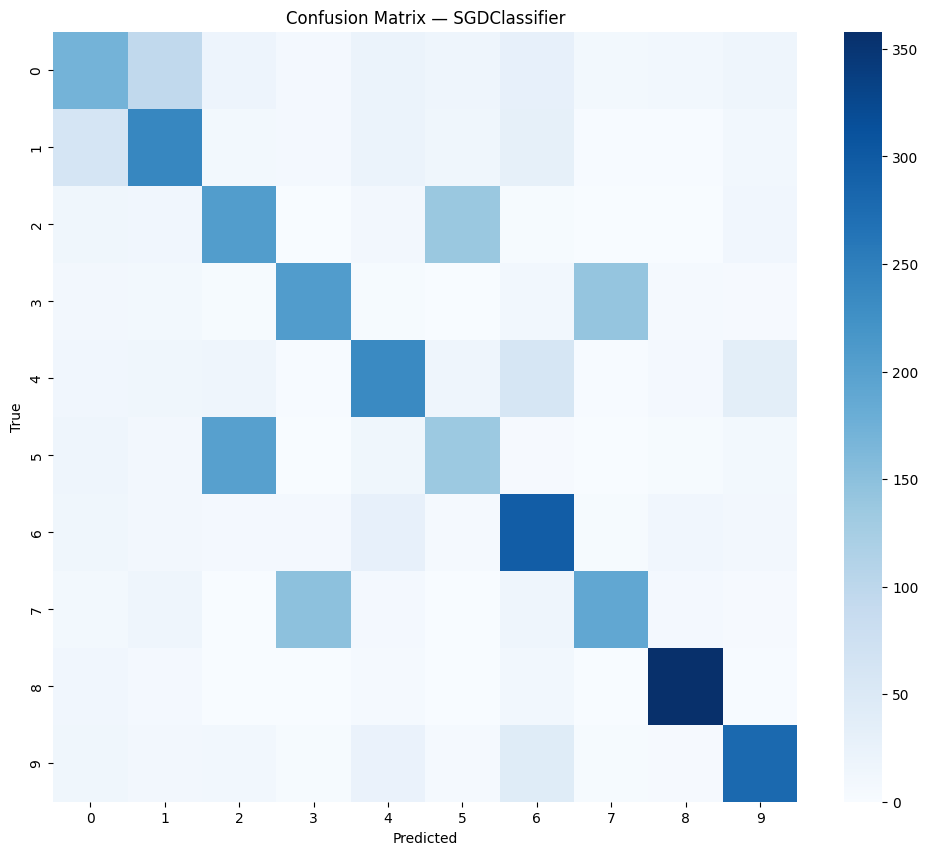

In [17]:
#Confusion Matrix for SGD Classifier

cm = confusion_matrix(y_test, y_pred_sgd, labels=sgd.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix — SGDClassifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [18]:
#SGD Classifier Metrics

sgd_acc  = accuracy_score(y_test, y_pred_sgd)
sgd_mac  = f1_score(y_test, y_pred_sgd, average="macro")
sgd_mic  = f1_score(y_test, y_pred_sgd, average="micro")

print("SGD Accuracy:", sgd_acc)
print("SGD Macro F1:", sgd_mac)
print("SGD Micro F1:", sgd_mic)


SGD Accuracy: 0.579
SGD Macro F1: 0.5757721152471544
SGD Micro F1: 0.579


In [19]:
#Random Forest Classifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_mac = f1_score(y_test, y_pred_rf, average="macro")
rf_mic = f1_score(y_test, y_pred_rf, average="micro")

print("RF Accuracy:", rf_acc)
print("RF Macro F1:", rf_mac)
print("RF Micro F1:", rf_mic)


RF Accuracy: 0.5705
RF Macro F1: 0.5655771006324707
RF Micro F1: 0.5705


In [20]:
#Logistic regression function
lr = LogisticRegression(
    max_iter=300,
    solver="saga",
    n_jobs=-1
)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Logistic regression Metrics
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_mac = f1_score(y_test, y_pred_lr, average="macro")
lr_mic = f1_score(y_test, y_pred_lr, average="micro")

print("LR Accuracy:", lr_acc)
print("LR Macro F1:", lr_mac)
print("LR Micro F1:", lr_mic)


LR Accuracy: 0.5775
LR Macro F1: 0.5770524746515167
LR Micro F1: 0.5775


In [21]:
# summary table -results

results = pd.DataFrame([
    ["SGDClassifier", sgd_acc, sgd_mac, sgd_mic],
    ["LogisticRegression", lr_acc, lr_mac, lr_mic],
    ["RandomForest", rf_acc, rf_mac, rf_mic],
], columns=["Model", "Accuracy", "Macro F1", "Micro F1"])
results = results.round(4)
results

,Model,Accuracy,Macro F1,Micro F1
0,SGDClassifier,0.5790,0.5758,0.5790
1,LogisticRegression,0.5775,0.5771,0.5775
2,RandomForest,0.5705,0.5656,0.5705


In [22]:
#Top words per venue for Logistic Regression

feature_names = tfidf.get_feature_names_out()

for idx, venue in enumerate(lr.classes_):
    topten_idx = lr.coef_[idx].argsort()[-10:]
    top_words = [feature_names[i] for i in topten_idx]
    print(f"\nTop words for venue: {venue}")
    print(top_words)



Top words for venue: 
['software', 'visualization', 'media', 'medical', 'research', 'health', 'evaluation', 'business', 'support', 'market']

Top words for venue: Lecture Notes in Computer Science
['agent', 'proof', 'problems', 'uml', 'logic', 'relations', 'paper', 'agents', 'software', 'present']

Top words for venue: global communications conference
['performance', 'users', 'interference', 'delay', 'wireless', 'scheme', 'networks', 'traffic', 'channel', 'network']

Top words for venue: intelligent robots and systems
['motion', 'environment', 'robotics', 'human', 'force', 'control', 'planning', 'robotic', 'robots', 'robot']

Top words for venue: international conference on acoustics, speech, and signal processing
['signals', 'word', 'signal', 'recognition', 'spoken', 'language', 'speaker', 'audio', 'acoustic', 'speech']

Top words for venue: international conference on communications
['antennas', 'access', 'cellular', 'transmission', 'codes', 'wireless', 'network', 'traffic', 'channe

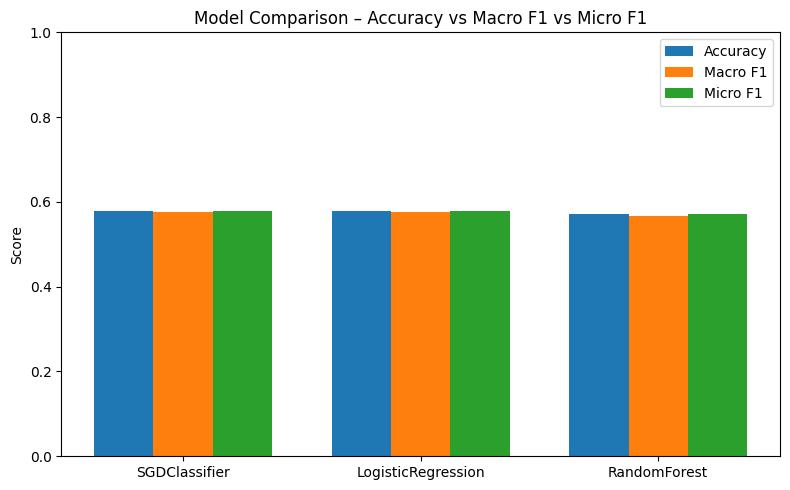

In [27]:
x = np.arange(len(results["Model"]))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, results["Accuracy"], width, label="Accuracy")
plt.bar(x,         results["Macro F1"], width, label="Macro F1")
plt.bar(x + width, results["Micro F1"], width, label="Micro F1")

plt.xticks(x, results["Model"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Comparison – Accuracy vs Macro F1 vs Micro F1")
plt.legend()

plt.tight_layout()
plt.show()
